# Setup

In [1]:
import pandas as pd 
from statsmodels.stats import multitest
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.io as pio
import seaborn as sns
import numpy as np

In [2]:
#esto es para forzar a plt a poner fondos blancos en las figuras aunque el tema del notebook sea oscuro
#plt.rcParams['axes.facecolor'] = 'white'
#plt.rcParams['figure.facecolor'] = 'white'
cmap = plt.get_cmap("tab10")
pio.templates.default = "seaborn"

sns.set_style("darkgrid", rc={'xtick.bottom': True})

In [3]:
data_processed = "../../../data/processed/"
graph_data = data_processed + "graph_data_nohubs/"
reports = "../../../reports/reports_nohubs/"

graph_node_data = pd.read_csv(graph_data+"nohub_graph_node_data.csv")
infomap_pathways = pd.read_csv(reports+"analisis_red_genes/infomap_pathways.csv", index_col=[0,1])
louvain_pathways = pd.read_csv(reports+"analisis_red_genes/louvain_pathways.csv", index_col=[0,1])

cols = ["comunidad","tamaño","mean_sim_lsa_0","entropia_0","top_monogram","top_5_monogram","top_monogram_score","top_5_monogram_score"]
infomap_summary = pd.read_pickle(reports+"infomap_summary.pkl")[cols]
louvain_summary = pd.read_pickle(reports+"louvain_summary.pkl")[cols]

# Corrección FDR

Corrijo los pvalores con FDR. Genero una columna que me dice si se rechazó la hipótesis nula para ese par cluster-pathway o no. Me quedo con las filas que tienen "reject" = True, es decir, se rechazó la hipótesis nula. Para esos pares cluster,pathway, tengo el odds ratio que me dice que tan significativa es la correlación entre ellos. Además, por la corrección FDR, se que entre esos pares tengo un 5% de falsos positivos.

In [4]:
infomap_pathways["pvalue"] = multitest.fdrcorrection(infomap_pathways.pvalue.values)[1]
infomap_pathways["reject"] = multitest.fdrcorrection(infomap_pathways.pvalue.values)[0] 

louvain_pathways["pvalue"] = multitest.fdrcorrection(louvain_pathways.pvalue.values)[1]
louvain_pathways["reject"] = multitest.fdrcorrection(louvain_pathways.pvalue.values)[0]

In [5]:
infomap_results = infomap_pathways[infomap_pathways.reject].drop(columns="reject")
louvain_results = louvain_pathways[louvain_pathways.reject].drop(columns="reject")

# Exploro ejemplos

Encontré pathways significativos para todos los clusters?

In [9]:
encontrados_infomap = len(infomap_results.reset_index().cluster.unique())
encontrados_louvain = len(louvain_results.reset_index().cluster.unique())
tot_infomap = len(infomap_summary)
tot_louvain = len(louvain_summary)

print(f"Encontré {encontrados_infomap} infomap y {encontrados_louvain} louvain")
print(f"{round((encontrados_infomap*100)/tot_infomap)}% infomap, {round((encontrados_louvain*100)/tot_louvain)}% louvain")

Encontré 861 infomap y 200 louvain
75% infomap, 68% louvain


Cuantos pathways tienen asociados esos clusters?

,num_pathways
cluster,
130,149
15,134
25,132
17,123
143,120
...,...
543,1
542,1
784,1


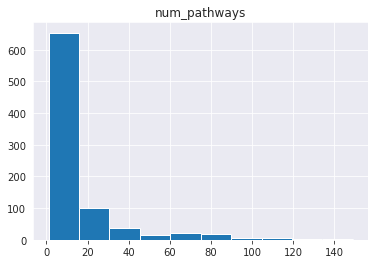

In [10]:
infomap_num_pathways = infomap_results.groupby("cluster").count().sort_values(by="pvalue",ascending=False).drop(columns="odds_ratio").rename(columns={"pvalue":"num_pathways"})
infomap_num_pathways.hist()
infomap_num_pathways

In [11]:
infomap_num_pathways.value_counts()

num_pathways
1               173
2               102
3                76
4                53
5                51
               ... 
70                1
71                1
73                1
74                1
149               1
Length: 92, dtype: int64

Text(0.5, 1.0, 'Num pathways encontrados por cluster - Infomap')

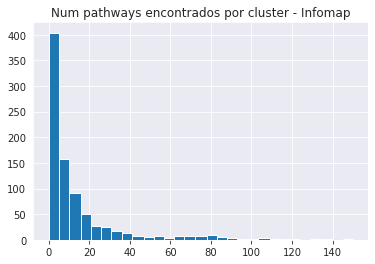

In [12]:
plt.hist(infomap_num_pathways.values, bins=np.round(np.linspace(0,150,30)), range=(0,40))
plt.title("Num pathways encontrados por cluster - Infomap")

In [13]:
louvain_num_pathways = louvain_results.groupby("cluster").count().sort_values(by="pvalue",ascending=False).drop(columns="odds_ratio").rename(columns={"pvalue":"num_pathways"})
louvain_num_pathways
fig = px.histogram(louvain_num_pathways,x="num_pathways")
fig.show()

Text(0.5, 1.0, 'Num pathways encontrados por cluster - Louvain')

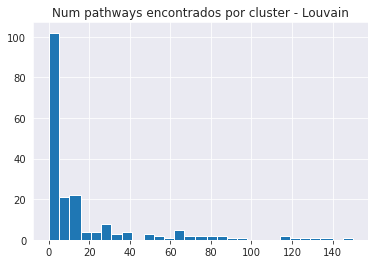

In [14]:
plt.hist(louvain_num_pathways.values, bins=np.round(np.linspace(0,150,30)), range=(0,40))
plt.title("Num pathways encontrados por cluster - Louvain")

Todos los pathways tienen asociadas comunidades? cuantas?

In [15]:
encontrados_infomap = len(infomap_results.reset_index().pathway.unique())
encontrados_louvain = len(louvain_results.reset_index().pathway.unique())
tot_pathways = 2017

print(f"Encontré {encontrados_infomap} infomap y {encontrados_louvain} louvain")
print(f"{round((encontrados_infomap*100)/tot_pathways)}% infomap, {round((encontrados_louvain*100)/tot_pathways)}% louvain")

Encontré 1529 infomap y 1108 louvain
76% infomap, 55% louvain


In [16]:
encontrados_infomap = set(infomap_results.reset_index().pathway.unique())
encontrados_louvain = set(louvain_results.reset_index().pathway.unique())

encontrados_ambos = encontrados_infomap|encontrados_louvain
porc = (len(encontrados_ambos)*100/tot_pathways)
print(f"{round(porc)}% tiene algún cluster asociado (de cualquier particion)")

76% tiene algún cluster asociado (de cualquier particion)


# Ejemplos

## Infomap

In [17]:
infomap_summary[infomap_summary.top_5_monogram.apply(lambda x: "von" in x)]

,comunidad,tamaño,mean_sim_lsa_0,entropia_0,top_monogram,top_5_monogram,top_monogram_score,top_5_monogram_score
407,525,11,0.92,0.43,willebrand,"[willebrand, von, bleeding, factor, platelet]",0.67,"[0.67, 0.52, 0.22, 0.22, 0.21]"


In [27]:
cluster = 1021
pathways = infomap_results.loc[cluster].sort_values(by="odds_ratio",ascending=False).index.values
infomap_results.loc[cluster].sort_values(by="odds_ratio",ascending=False)

,odds_ratio,pvalue
pathway,,
35392,5771.000000,0.000022
35304,106.543210,0.003065
35385,80.953052,0.004541


In [19]:
infomap_summary[infomap_summary.comunidad == cluster]

,comunidad,tamaño,mean_sim_lsa_0,entropia_0,top_monogram,top_5_monogram,top_monogram_score,top_5_monogram_score
19,40,43,0.45,0.61,hepatitis,"[hepatitis, liver, inflammation, cirrhosis, vi...",0.8,"[0.8, 0.42, 0.1, 0.1, 0.1]"


In [28]:
graph_node_data[graph_node_data.comunidades_infomap == cluster]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
15997,29172,C1868120,"POSTAXIAL POLYDACTYLY, TYPE B",disease,disgenet,1021.0,175.0,3.0,0.0,1.0
15998,32073,C3887487,Postaxial polydactyly type A,disease,disgenet,1021.0,175.0,6.0,0.0,1.0
16000,22127,C0220697,"POLYDACTYLY, POSTAXIAL",disease,disgenet,1021.0,175.0,4.0,0.0,1.0
16001,32946,C4282400,"Polydactyly, Postaxial, Type A1",disease,disgenet,1021.0,175.0,3.0,0.0,1.0
22756,33486,C4539976,"POLYDACTYLY, POSTAXIAL, TYPE A7",disease,disgenet,1021.0,175.0,1.0,0.0,1.0
24604,34032,C4748277,"POLYDACTYLY, POSTAXIAL, TYPE A8",disease,disgenet,1021.0,175.0,1.0,0.0,1.0
31051,12877,60550_9893_29130_8266_11187_14090_32603_32785_19673_19674_20927_11813_12059_17531_17532_17533_17534,postaxial polydactyly,bert_group,primekg,1021.0,175.0,0.0,0.0,7.0
31052,31831,C3808889,"POLYDACTYLY, POSTAXIAL, TYPE A6",disease,disgenet,1021.0,175.0,1.0,0.0,1.0


In [21]:
pd.set_option('display.max_colwidth', None)

In [29]:
graph_node_data.set_index("node_index").loc[pathways][["node_name"]]

,node_name
node_index,
35392,GLI proteins bind promoters of Hh responsive genes to promote transcription
35304,Hedgehog 'off' state
35385,Hedgehog 'on' state


Armar un pipeline "keyword" -> cluster -> wordcloud, pathways

## Louvain

In [23]:
cluster = 11
pathways = louvain_results.loc[cluster].sort_values(by="odds_ratio",ascending=False).index.values
louvain_results.loc[cluster].sort_values(by="odds_ratio",ascending=False)

,odds_ratio,pvalue
pathway,,
34941,inf,1.067596e-03
35785,inf,1.067596e-03
35920,82.573153,4.876582e-07
34561,65.241786,1.392513e-10
35918,55.045455,1.347515e-06
...,...,...
34729,4.278235,7.053857e-04
34820,4.000132,3.040710e-03
35548,2.590622,5.472585e-06


In [24]:
louvain_summary[louvain_summary.comunidad == cluster]

,comunidad,tamaño,mean_sim_lsa_0,entropia_0,top_monogram,top_5_monogram,top_monogram_score,top_5_monogram_score
51,11,78,0.29,0.64,hepatitis,"[hepatitis, liver, cirrhosis, chronic, virus]",0.68,"[0.68, 0.5, 0.16, 0.13, 0.12]"


In [25]:
graph_node_data[graph_node_data.comunidades_louvain == cluster]

,node_index,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
23,32933,C4277682,Chemical and Drug Induced Liver Injury,disease,disgenet,40.0,11.0,404.0,0.0,2.0
519,19954,C0023890,Liver Cirrhosis,disease,disgenet,42.0,11.0,103.0,0.0,10.0
529,24832,C0524909,"Hepatitis B, Chronic",disease,disgenet,40.0,11.0,8.0,0.0,1.0
530,19955,C0023891,"Liver Cirrhosis, Alcoholic",disease,disgenet,42.0,11.0,30.0,0.0,2.0
531,19589,C0019163,Hepatitis B,disease,disgenet,40.0,11.0,32.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...
34619,19588,C0019159,Hepatitis A,disease,disgenet,40.0,11.0,0.0,0.0,3.0
34620,21257,C0085293,Hepatitis E,disease,disgenet,40.0,11.0,0.0,0.0,2.0
34778,25005,C0600452,Hepatopulmonary Syndrome,disease,disgenet,40.0,11.0,0.0,0.0,1.0
34779,23881,C0342748,Glycogen synthase deficiency,disease,disgenet,40.0,11.0,0.0,0.0,1.0


In [26]:
graph_node_data.set_index("node_index").loc[pathways]

,node_id,node_name,node_type,node_source,comunidades_infomap,comunidades_louvain,degree_gda,degree_pp,degree_dd
node_index,,,,,,,,,
34941,R-HSA-381070,IRE1alpha activates chaperones,pathway,primekg_REACTOME,NaN,NaN,0.0,3.0,0.0
35785,R-HSA-8875791,MET activates STAT3,pathway,primekg_REACTOME,NaN,NaN,0.0,3.0,0.0
35920,R-HSA-9020933,Interleukin-23 signaling,pathway,primekg_REACTOME,NaN,NaN,0.0,9.0,0.0
34561,R-HSA-189483,Heme degradation,pathway,primekg_REACTOME,NaN,NaN,0.0,15.0,0.0
35918,R-HSA-9020591,Interleukin-12 signaling,pathway,primekg_REACTOME,NaN,NaN,0.0,10.0,0.0
...,...,...,...,...,...,...,...,...,...
34729,R-HSA-216083,Integrin cell surface interactions,pathway,primekg_REACTOME,NaN,NaN,0.0,85.0,0.0
34820,R-HSA-3000178,ECM proteoglycans,pathway,primekg_REACTOME,NaN,NaN,0.0,76.0,0.0
35548,R-HSA-6798695,Neutrophil degranulation,pathway,primekg_REACTOME,NaN,NaN,0.0,478.0,0.0
